In [1]:
%env OMP_NUM_THREADS=8
%env MKL_NUM_THREADS=8

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib as mpl
from itertools import product
import scipy as sp
import scipy.interpolate

rc_cmufonts = {
    "font.family": "normal",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [], 
    }
fs = 10
font = {'size'   : fs}

mpl.rc('font', **font)
mpl.rcParams.update(rc_cmufonts)
mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from IPython.kernel.zmq.pylab import backend_inline
cfg = backend_inline.InlineBackend.instance()# InlineBackendConfig.instance()
cfg.figure_format = 'svg' # 'png' to switch back

sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
sns.mpl.rcParams['legend.frameon'] = 'False'
#sns.rcParams['legend.frameon'] = 'False'
palette = sns.color_palette() 
fig_format = 'pgf'

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

env: OMP_NUM_THREADS=8
env: MKL_NUM_THREADS=8


/home/hariyuki/apd/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import sys
sys.path.append('../src/')
sys.path.append('../classify/')

In [2]:
data_dirname = '../data/'
data_filename = 'data.npz'
#cv_filename = 'phys_cv_indices_73.npz'
cv_filename = '2phys_cv_indices_73.npz'
eps = 10.*np.spacing(1.)

df = np.load(data_dirname+data_filename)
data, labels = df['data'], df['labels']
data = np.reshape(data, [data.shape[0], -1], order='F')
tmp = np.median(data, axis=0)
ind = np.where(np.abs(tmp) > eps)[0]
data = data[:, ind]

df = np.load(data_dirname+cv_filename)
train_indices, test_indices = df['train_indices'], df['test_indices']

## Random Forest

In [ ]:
from rand_forest import check_lambda
from rand_forest import check_vb
from rand_forest import main_func


datanm = '../data/a.npz'
#Cs = [100., 50., 10., 5., 1., 0.75, 0.5, 0.25, 0.01]

#crit = 'entropy'
crit = 'gini'
if crit == 'gini':
    mdep = range(1, 101)#[1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]#, 35, 40, 45, 50]
    nest = range(1, 101)#[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


    bdep = 18
    bnest = 45
    #dep = 35
if crit == 'entropy':
        # bad
    mdep = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


#Cs = (1./np.arange(0.01, 2.01, 0.1)).tolist()
#a = check_lambda(datanm, samples_per_class = 20, depv = mdep, num_classes = 36, num_iter = 100, criterion = crit)
a = check_vb(datanm, samples_per_class = 20, depv = bdep, nest = bnest, num_classes = 36, num_iter = 100, criterion = crit)
#l = main_func(datanm, samples_per_class = 20, depv = mdep, nest = nest, num_classes = 36, criterion = crit, num_iter = 100)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

def check_lambda(
    data, labels, train_indices, test_indices, depth, n_estimators,
    criterion, save_filename=None, njobs=8
):
    num_iter = len(train_indices)    
    ans = np.zeros((num_iter, len(depth), len(n_estimators), 2))
    
    uni_labels = np.unique(labels)
    for k in xrange(num_iter):
        train_index = train_indices[k]
        test_index = test_indices[k]
        
        train_data = [data[train_index, :], labels[train_index]]
        valid_data = [data[test_index, :], labels[test_index]]
        
        # decision trees are not sensitive to standard scaling, but anyway
        meanX = np.median(train_data[0], axis=0, keepdims=True)
        stdX = np.std(train_data[0], axis=0, keepdims=True, ddof=1)
        train_data[0] -= meanX
        train_data[0] /= stdX
        
        valid_data[0] -= meanX
        valid_data[0] /= stdX
        
        for i, d in enumerate(depth):
            for j, n in enumerate(n_estimators):
                clf = RandomForestClassifier(
                    n_estimators=n,
                    criterion=criterion,
                    max_depth=d,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    min_weight_fraction_leaf=0.0,
                    max_features='auto',
                    max_leaf_nodes=None,
                    bootstrap=True,
                    oob_score=False,
                    n_jobs=njobs,
                    random_state=None,
                    verbose=0,
                    warm_start=False,
                    class_weight=None
                )
                clf.fit(train_data[0], train_data[1])

                out_train = clf.predict_proba(train_data[0])
                out_valid = clf.predict_proba(valid_data[0])

                ans[k, i, j, 0] += log_loss(train_data[1], out_train, labels=uni_labels)
                ans[k, i, j, 1] += log_loss(valid_data[1], out_valid, labels=uni_labels)
        if save_filename is not None:
            np.savez_compressed(
                save_filename, ans=ans, n_estimators=n_estimators,
                depth=depth
            )
    return ans

In [5]:
save_dirname = '../result/'
save_filename = 'check_d_e_random_forest'

crit = 'gini'

#step = 5
#mdep = step+np.arange(0, 100, step)
#nest = step+np.arange(0, 100, step)

mdep = 1+np.arange(50)
nest = 1+np.arange(50)



In [ ]:
ans = check_lambda(
    data, labels, train_indices, test_indices, depth=mdep, n_estimators=nest,
    criterion=crit, save_filename=save_dirname+save_filename
)

In [6]:
save_dirname = '../result/'
save_filename = 'check_d_e_random_forest.npz'

df = np.load(save_dirname+save_filename)
ans = np.mean(df['ans'], axis=0)
ind = np.where(ans[:, :, 1] == ans[:, :, 1].min())
rf_best_depth = mdep[ind[0]][0]
rf_best_nest = nest[ind[1]][0]
print('Best depth=%d, best number of estimators=%d' % (rf_best_depth, rf_best_nest))

Best depth=43, best number of estimators=44


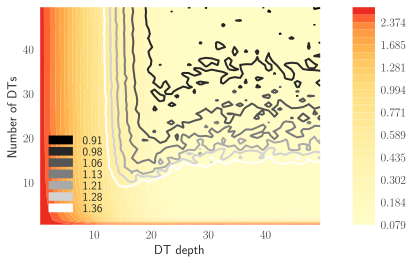

In [38]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches


ad = 4#24
at = 4#24
md = 50#400
mt = 50#400
dstep = 5
tstep = 5

colname = cm.YlOrRd

a = ans.copy()

plt.clf()
ax = plt.subplot(111)
#a = a[ad:md, at:mt, : ]
vmx = a[ad:md, at:mt, :].max()
b = abs(a[:, :, 1] - a[:, :, 0]).T
numpoints = 30
levels1 = np.linspace(np.exp(-a[:,:,0].max()), np.exp(-a[:,:,0].min()), numpoints)
levels1 = -np.log(levels1)
levels1.sort()
im = ax.contourf(
    a[:, :, 0].T, interpolation='none', levels=levels1,
    origin='lower', vmin=0, vmax=vmx, cmap=colname
)
levels = np.linspace(a[:, :, 1].min(), 1.5*a[:, :, 1].min(), 7) #np.arange(0, 0.5, 0.1)
levels = np.round(levels, 2)
CS = ax.contour(a[:,:,1].T, levels, linewidths=2,  origin='lower', cmap=cm.gray)



#l, b, w, h = plt.gca().get_position().bounds
#ll, bb, ww, hh = CB.ax.get_position().bounds
#CB.ax.set_position([ll, b - 0.1*h, ww, h*0.8])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="8%", pad=0.45)
CBI = plt.colorbar(im, cax=cax)

lv_patch = []

cols = CS.tcolors

#x_value = -5.
#y_value = 0.48
x_value = -13.9
y_value = -0.1
axbox = ax.get_position()

for i in xrange(len(levels)):
    lv_patch = lv_patch + [mpatches.Patch(color=cols[i][0], label=str(levels[i]))]
plt.legend(handles=lv_patch, loc = (axbox.x0 + x_value, axbox.y0 + y_value), labelspacing = 0.05)


ax.set_xlabel('DT depth')
ax.set_ylabel('Number of DTs')

#ax.set_xlim(ad,md)
#ax.set_ylim(at,mt)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

CBI.outline.set_visible(False)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

#plt.savefig('rand_forest.' + fig_format, bbox_inches='tight')
plt.show()

#np.trunc(a[4:50,4:50,0])


In [77]:
def check_vb(
    data, labels, train_indices, test_indices, depth, n_estimators, criterion,
    max_samples_per_class=10, random_state=None, save_filename=None, njobs=1
):
    if random_state is not None:
        np.random.seed(random_state)
    num_iter = len(train_indices)
    ans = np.zeros((num_iter, len(depth), len(n_estimators), max_samples_per_class, 2))
    
    uni_labels = np.unique(labels)
    for k_iter in range(num_iter):
        train_index = np.array(train_indices[k_iter])
        test_index = test_indices[k_iter]
        
        current_train_labels = labels[train_index]
        train_labels_n = []
        for k_label in range(len(uni_labels)):
            ind = np.where(current_train_labels == uni_labels[k_label])[0]
            np.random.shuffle(ind)
            ind = ind[:max_samples_per_class]
            train_labels_n.append(train_index[ind])
        
        valid_data = [data[test_index, :], labels[test_index]]
        for n_samples in range(max_samples_per_class):
            ind_train = [x[:n_samples+1].tolist() for x in train_labels_n]
            ind_train = list(reduce(lambda x, y: x+y, ind_train, []))
            ctrain_data = [data[ind_train, :], labels[ind_train]]
            meanX = np.median(ctrain_data[0], axis=0, keepdims=True)
            stdX = np.std(ctrain_data[0], axis=0, keepdims=True, ddof=1)
            ctrain_data[0] -= meanX
            ctrain_data[0] /= stdX
        
            cvalid_data = valid_data[0] - meanX
            cvalid_data /= stdX
            for i, d in enumerate(depth):
                for j, n in enumerate(n_estimators):
                    clf = RandomForestClassifier(
                        n_estimators=n,
                        criterion=criterion,
                        max_depth=d,
                        min_samples_split=2,
                        min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0,
                        max_features='auto',
                        max_leaf_nodes=None,
                        bootstrap=True,
                        oob_score=False,
                        n_jobs=njobs,
                        random_state=None,
                        verbose=0,
                        warm_start=False,
                        class_weight=None
                    )
                    clf.fit(ctrain_data[0], ctrain_data[1])

                    out_train = clf.predict_proba(ctrain_data[0])
                    out_valid = clf.predict_proba(cvalid_data)


                    ans[k_iter, i, j, n_samples, 0] = log_loss(
                        ctrain_data[1], out_train, labels=uni_labels
                    )
                    ans[k_iter, i, j, n_samples, 1] = log_loss(
                        valid_data[1], out_valid, labels=uni_labels
                    )
        if save_filename is not None:
            np.savez_compressed(
                save_filename, ans=ans, depth=depth, n_estimators=n_estimators,
                max_samples_per_class=max_samples_per_class
            )
    return ans


In [78]:
random_state = 198
save_dirname = '../result/'
save_filename = 'check_vb_rf'
ans1 = check_vb(
    data, labels, train_indices, test_indices, depth=[rf_best_depth],
    n_estimators=[rf_best_nest], criterion='gini',
    max_samples_per_class=16, random_state=random_state,
    save_filename=save_dirname+save_filename, njobs=6
)
# unnormalized in file!

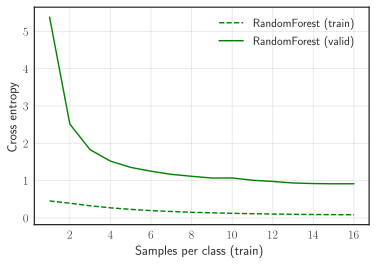

In [90]:
dirname_result = '../result/'
filename_rf = 'check_vb_rf.npz'

df = np.load(dirname_result+filename_rf)
ans_rf = np.mean(df['ans'], axis=0)[0, 0] # len(Cs) = 1, Cs = [Cb]

number_of_observations = 16
number_of_observations = min(number_of_observations, ans_rf.shape[0])
#, ans_lc_lr_ovo.shape[0])

t = 1+np.arange(number_of_observations)
ans_rf = ans_rf[:number_of_observations, :]

plt.plot(t, ans_rf[:, 0], '--', color='g', label='RandomForest (train)')
plt.plot(t, ans_rf[:, 1], '-', color='g', label='RandomForest (valid)')

plt.xlabel('Samples per class (train)')
plt.ylabel('Cross entropy')
plt.legend(loc=1)
plt.grid(alpha=0.5)
#plt.ylim(0.5, 3.0)
plt.show()

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def main_func(
    data, labels, train_indices, test_indices, depth,
    n_estimators, criterion='gini',
    save_filename=None, scale='standard-median',
    average='macro', njobs=1
):
    num_iter = len(train_indices)
    uni_labels = np.unique(labels)
    num_classes = len(uni_labels)
    
    recall = np.zeros((num_iter, num_classes+1, 2))
    precision = np.zeros((num_iter, num_classes+1, 2))
    f1 = np.zeros((num_iter, num_classes+1, 2))
    accuracy = np.zeros((num_iter, 2))
    logloss = np.zeros((num_iter, 2))
    
    for k_iter in range(num_iter):
        train_index = train_indices[k_iter]
        test_index = test_indices[k_iter]
        
        
        train_data = [data[train_index, :], labels[train_index]]
        valid_data = [data[test_index , :], labels[test_index ]]
        
        if scale.startswith('standard'):
            if scale == 'standard-median':
                meanX = np.median(train_data[0], axis=0, keepdims=True)
            elif scale =='standard-mean':
                meanX = np.mean(train_data[0], axis=0, keepdims=True)
            else:
                raise ValueError
            stdX = np.std(train_data[0], axis=0, keepdims=True, ddof=1)
            train_data[0] -= meanX
            train_data[0] /= stdX

            valid_data[0] -= meanX
            valid_data[0] /= stdX
        elif scale == 'minmax':
            funsc = lambda x: (
                x - x.min(axis=1, keepdims=True)
            ) / (
                x.max(axis=1, keepdims=True) - x.min(axis=1, keepdims=True)
            )
            
            train_data[0] = funsc(train_data[0])
            valid_data[0] = funsc(valid_data[0])
        
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=depth,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            bootstrap=True,
            oob_score=False,
            n_jobs=njobs,
            random_state=None,
            verbose=0,
            warm_start=False,
            class_weight=None
        )
        clf.fit(train_data[0], train_data[1])

        
        out_train = clf.predict_proba(train_data[0])
        out_valid = clf.predict_proba(valid_data[0])

        logloss[k_iter, 0] = log_loss(train_data[1], out_train, labels=uni_labels)
        logloss[k_iter, 1] = log_loss(valid_data[1], out_valid, labels=uni_labels)

        out_train = clf.predict(train_data[0])
        out_valid = clf.predict(valid_data[0])

        accuracy[k_iter, 0] = accuracy_score(train_data[1], out_train)
        accuracy[k_iter, 1] = accuracy_score(valid_data[1], out_valid)
        
        precision[k_iter, :-1, 0] = precision_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        precision[k_iter, -1, 0] = precision_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        precision[k_iter, :-1, 1] = precision_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        precision[k_iter, -1, 1] = precision_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        recall[k_iter, :-1, 0] = recall_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        recall[k_iter, -1, 0] = recall_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        recall[k_iter, :-1, 1] = recall_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        recall[k_iter, -1, 1] = recall_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        f1[k_iter, :-1, 0] = f1_score(
            train_data[1], out_train, average=None, labels=uni_labels
        )
        f1[k_iter, -1, 0] = f1_score(
            train_data[1], out_train, average=average, labels=uni_labels
        )
        f1[k_iter, :-1, 1] = f1_score(
            valid_data[1], out_valid, average=None, labels=uni_labels
        )
        f1[k_iter, -1, 1] = f1_score(
            valid_data[1], out_valid, average=average, labels=uni_labels
        )

        np.savez_compressed(
            save_filename, accuracy=accuracy, recall=recall, f1=f1,
            precision=precision, 
            logloss=logloss
        )
    return accuracy, precision, recall, f1, logloss


In [9]:
save_dirname = '../result/'
save_filename = 'tuned_rf'

rv = main_func(
    data, labels, train_indices, test_indices, rf_best_depth,
    rf_best_nest, criterion='gini',
    save_filename=save_dirname+save_filename,
    average='macro', njobs=6
)

In [63]:
data_dirname = '../data/'
cv_filename2 = 'phys_cv_indices_732.npz'
eps = 10.*np.spacing(1.)

df = np.load(data_dirname+cv_filename2)
train_indices2, test_indices2 = df['train_indices'], df['test_indices']

In [ ]:
save_dirname = '../result/'
save_filename = 'tuned_rf2'

rv2 = main_func(
    data, labels, train_indices2, test_indices2, rf_best_depth,
    rf_best_nest, criterion='gini',
    save_filename=save_dirname+save_filename,
    average='macro', njobs=6
)

In [10]:
import pandas as pd

save_dirname = '../result/'
filenames = [
    'tuned_rf.npz'
]

cum_df = {
    'accuracy (train)': [],
    'accuracy (valid)': [],
    'recall (train)': [],
    'recall (valid)': [],
    'precision (train)': [],
    'precision (valid)': [],
    'f1 (train)': [],
    'f1 (valid)': []
}

cum_df2 = {
    'accuracy (train)': [],
    'accuracy (valid)': [],
    'recall (train)': [],
    'recall (valid)': [],
    'precision (train)': [],
    'precision (valid)': [],
    'f1 (train)': [],
    'f1 (valid)': []
}

for filename in filenames:
    df = np.load(save_dirname+filename)
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        tmp = np.mean(df[metric], axis=0)
        if tmp.ndim > 1:
            tmp = tmp[-1, :]
        cum_df['%s (train)' % (metric)].append(tmp[0])
        cum_df['%s (valid)' % (metric)].append(tmp[1])
    
    df = np.load(save_dirname+filename.replace('.npz', '2.npz'))
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        tmp = np.mean(df[metric], axis=0)
        if tmp.ndim > 1:
            tmp = tmp[-1, :]
        cum_df2['%s (train)' % (metric)].append(tmp[0])
        cum_df2['%s (valid)' % (metric)].append(tmp[1])
    
cum_df = pd.DataFrame(cum_df)
cum_df['alg'] = ['RandomForest']
cum_df2 = pd.DataFrame(cum_df2)
cum_df2['alg'] = ['RandomForest']

In [61]:
cum_df

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.943684,1.0,0.935263,1.0,0.942185,1.0,0.945463,RandomForest


In [11]:
cum_df

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.948596,1.0,0.937566,1.0,0.943352,1.0,0.948194,RandomForest


In [66]:
cum_df2

,accuracy (train),accuracy (valid),f1 (train),f1 (valid),precision (train),precision (valid),recall (train),recall (valid),alg
0,1.0,0.944211,1.0,0.933176,1.0,0.939606,1.0,0.944444,RandomForest


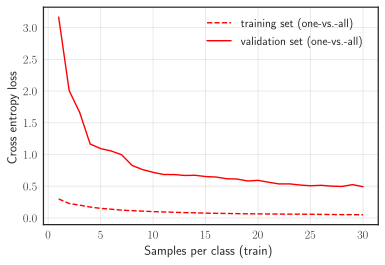

In [87]:
dirname_result = '../result/'
filename_lc_art_lr_ovr = 'artificial_duplicate_check_vb_ovr_logreg.npz'

df = np.load(dirname_result+filename_lc_art_lr_ovr)
ans_lc_art_lr_ovr = np.mean(df['ans'][:7], axis=0)[0] # len(Cs) = 1, Cs = [Cb]

number_of_observations = 30
number_of_observations = min(
    number_of_observations,
    ans_lc_art_lr_ovr.shape[0],
)

t = 1+np.arange(number_of_observations)
ans_lc_art_lr_ovr = ans_lc_art_lr_ovr[:number_of_observations, :]

plt.plot(t, ans_lc_art_lr_ovr[:, 0], '--', color='r', label='training set (one-vs.-all)')
plt.plot(t, ans_lc_art_lr_ovr[:, 1], '-', color='r', label='validation set (one-vs.-all)')

plt.xlabel('Samples per class (train)')
plt.ylabel('Cross entropy loss')
plt.legend(loc=1)
plt.grid(alpha=0.5)
plt.show()

[50.]
[50.]


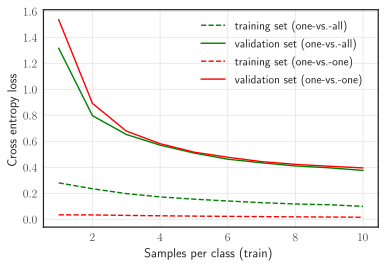

In [89]:
dirname_result = '../result/'
filename_lc_lr_ovr = 'check_vb_ovr_logreg.npz'
filename_lc_lr_ovo = 'check_vb_ovo_logreg.npz'

df = np.load(dirname_result+filename_lc_lr_ovr)
ans_lc_lr_ovr = np.mean(df['ans'][:7], axis=0)[0] # len(Cs) = 1, Cs = [Cb]
print(df['Cs'])

df = np.load(dirname_result+filename_lc_lr_ovo)
ans_lc_lr_ovo = np.mean(df['ans'], axis=0)[0] # len(Cs) = 1, Cs = [Cb]
print(df['Cs'])

number_of_observations = 10
number_of_observations = min(
    number_of_observations,
    ans_lc_lr_ovr.shape[0],
    ans_lc_lr_ovo.shape[0]
)

t = 1+np.arange(number_of_observations)
ans_lc_lr_ovr = ans_lc_lr_ovr[:number_of_observations, :]
ans_lc_lr_ovo = ans_lc_lr_ovo[:number_of_observations, :]

plt.plot(t, ans_lc_lr_ovr[:, 0], '--', color='g', label='training set (one-vs.-all)')
plt.plot(t, ans_lc_lr_ovr[:, 1], '-', color='g', label='validation set (one-vs.-all)')
plt.plot(t, ans_lc_lr_ovo[:, 0], '--', color='r', label='training set (one-vs.-one)')
plt.plot(t, ans_lc_lr_ovo[:, 1], '-', color='r', label='validation set (one-vs.-one)')

plt.xlabel('Samples per class (train)')
plt.ylabel('Cross entropy loss')
plt.legend(loc=1)
plt.grid(alpha=0.5)
plt.show()